<a href="https://colab.research.google.com/github/A01793509/Equipo_44/blob/main/Avance4_44.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🚀 **Avance 4. Modelos alternativos**: Explorar una gama diversa de técnicas y enfoques con el fin de identificar el de mejor desempeño en el conjunto de datos en cuestión. Encontrar la configuración óptima que maximiza el rendimiento del modelo en una tarea específica.

📑 **Asignatura**: Proyecto Integrador

📘 **Proyecto**: LunchForecast AI: Optimizador de reservas de almuerzos empresariales basado en inteligencia artificial.

📚 **Equipo**: 44

🧑 **Alumnos**:

Alberto José García Porras (Matrícula No. **A01793509**)

Erick Johan Najera Olivero (Matrícula No. **A01793506**)

Carlos Julio León Caicedo (Matrícula No. **A01793947**)

👩 **Profesores**:

Dra. Grettel Barceló Alonso

Dr. Luis Eduardo Falcón Morales

Dr. Guillermo Mota

📅 Mayo 26 del 2024

In [213]:
#Importamos las librerías que utilizaremos para la ejecución de la actividad
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import math
import numpy as np
import warnings
import statsmodels.api as sm
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import boxcox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor


👣**Obtener Datos**: Cargamos el archivo CSV con la información del consumo del casino desde enero del 2021 hasta marzo del 2024.

In [214]:
dfCasinoConsumo = pd.read_csv("DatosConsumoCasino.csv",sep=";")
#dfCasinoConsumo = pd.read_csv("Consumo_test.csv",sep=";")
dfCasinoConsumoOriginal = dfCasinoConsumo
dfCasinoConsumo.head()

,Consecutivo,IdProducto,cod lector,Cod comedor,Identificacion persona,Fecha Consumo,Detalle,Nro empleados,Tipo Empleado,Nivel,Porcentaje apoyo,Invitado,Ing x planta
0,825979,2.0,0,1001,100001,2021-01-03,ALMUERZO,3486,Operativo,OPER,0,0,1
1,825980,2.0,0,1001,100002,2021-01-03,ALMUERZO,3486,Administrativo,ANAL,90,0,1
2,825981,2.0,0,1001,100003,2021-01-03,ALMUERZO,3486,Operativo,OPER,0,0,1
3,825982,2.0,1,1001,100004,2021-01-03,ALMUERZO,3486,Operativo,OPER,90,0,1
4,825983,2.0,0,1001,100005,2021-01-03,ALMUERZO,3486,Administrativo,OPER,0,0,1



---

☝**NOTA:** En este entregable iniciaremos aplicando los ajustes detectados en los entregables anteriores, referentes a la depuración de los datos y la ingeniería de características. Por lo tanto, la creación del baseline solicitando en esta entrega se identificará más adelante en la sección 2 del presente notebook.


---




---


👣 **SECCIÓN 1:** Limpieza y ajuste del conjunto de datos.



---



In [215]:
# Convierte la columna 'fecha del consumo' a tipo datetime si aún no lo está
dfCasinoConsumo['Fecha Consumo'] = pd.to_datetime(dfCasinoConsumo['Fecha Consumo'], format='%Y-%m-%d', errors='coerce')
#dfCasinoConsumo = dfCasinoConsumo.set_index('Fecha Consumo')
dfCasinoConsumo.head()

,Consecutivo,IdProducto,cod lector,Cod comedor,Identificacion persona,Fecha Consumo,Detalle,Nro empleados,Tipo Empleado,Nivel,Porcentaje apoyo,Invitado,Ing x planta
0,825979,2.0,0,1001,100001,2021-01-03,ALMUERZO,3486,Operativo,OPER,0,0,1
1,825980,2.0,0,1001,100002,2021-01-03,ALMUERZO,3486,Administrativo,ANAL,90,0,1
2,825981,2.0,0,1001,100003,2021-01-03,ALMUERZO,3486,Operativo,OPER,0,0,1
3,825982,2.0,1,1001,100004,2021-01-03,ALMUERZO,3486,Operativo,OPER,90,0,1
4,825983,2.0,0,1001,100005,2021-01-03,ALMUERZO,3486,Administrativo,OPER,0,0,1


In [216]:
#En el análisis, habíamos notado que existían valores de 'ALMUERZO' en minúsculas en el campo 'DETALLE'
#Por lo anterior, procederemos a pasar a mayúsculas el contenido de la columna antes de proceder con el borrado
dfCasinoConsumo['Detalle'] = dfCasinoConsumo['Detalle'].str.upper()

#Filtramos el dataFrame para conservar solo las filas donde 'DETALLE' es igual a 'ALMUERZO' y lo guardamos en un
#nuevo dataframe para evitar SettingWithCopyWarning
dfCasinoAlmuerzos = dfCasinoConsumo[dfCasinoConsumo['Detalle'] == 'ALMUERZO'].copy()

In [217]:
#Eliminamos las columnas que no consideramos relevantes según hallazgos en la fase de exploración
dfCasinoConsumo=dfCasinoConsumo.drop(columns=['Consecutivo', 'Detalle','IdProducto', 'cod lector', 'Cod comedor', 'Identificacion persona', 'Invitado','Ing x planta','Nro empleados','Nivel'])
dfCasinoConsumo.head()

,Fecha Consumo,Tipo Empleado,Porcentaje apoyo
0,2021-01-03,Operativo,0
1,2021-01-03,Administrativo,90
2,2021-01-03,Operativo,0
3,2021-01-03,Operativo,90
4,2021-01-03,Administrativo,0


**pd.get_dummies():** Esta función se utilizó para convertir las variables categóricas Tipo Empleado y Porcentaje apoyo en un conjunto de variables indicadoras (también llamadas variables dummy). Es una técnica comúnmente usada en la preparación de datos para modelos de aprendizaje automático, particularmente útil cuando se trata con modelos que requieren entradas numéricas exclusivamente.

In [218]:
#Procedemos a realizar la codificación de las columnas categóricas
dfCasinoAlmuerzosCodificado = pd.get_dummies(dfCasinoConsumo, columns=['Tipo Empleado',  'Porcentaje apoyo'])
dfCasinoAlmuerzosCodificado.head()

,Fecha Consumo,Tipo Empleado_Administrativo,Tipo Empleado_Aprendices,Tipo Empleado_Operativo,Porcentaje apoyo_0,Porcentaje apoyo_30,Porcentaje apoyo_90,Porcentaje apoyo_100
0,2021-01-03,False,False,True,True,False,False,False
1,2021-01-03,True,False,False,False,False,True,False
2,2021-01-03,False,False,True,True,False,False,False
3,2021-01-03,False,False,True,False,False,True,False
4,2021-01-03,True,False,False,True,False,False,False


In [219]:
#Para que el modelo que desarrollaremos más adelante funcione de una mejor manera,
#procederemos a convertir los valores booleanos a números.
#Recorremos todas las columnas y al identificar una booleana, la convertiremos en número.
for col in dfCasinoAlmuerzosCodificado.columns:
    if dfCasinoAlmuerzosCodificado[col].dtype == bool:
        dfCasinoAlmuerzosCodificado[col] = dfCasinoAlmuerzosCodificado[col].astype(int)

dfCasinoAlmuerzosCodificado.head(5)

,Fecha Consumo,Tipo Empleado_Administrativo,Tipo Empleado_Aprendices,Tipo Empleado_Operativo,Porcentaje apoyo_0,Porcentaje apoyo_30,Porcentaje apoyo_90,Porcentaje apoyo_100
0,2021-01-03,0,0,1,1,0,0,0
1,2021-01-03,1,0,0,0,0,1,0
2,2021-01-03,0,0,1,1,0,0,0
3,2021-01-03,0,0,1,0,0,1,0
4,2021-01-03,1,0,0,1,0,0,0


In [220]:
dfCasinoAlmuerzosCodificado

,Fecha Consumo,Tipo Empleado_Administrativo,Tipo Empleado_Aprendices,Tipo Empleado_Operativo,Porcentaje apoyo_0,Porcentaje apoyo_30,Porcentaje apoyo_90,Porcentaje apoyo_100
0,2021-01-03,0,0,1,1,0,0,0
1,2021-01-03,1,0,0,0,0,1,0
2,2021-01-03,0,0,1,1,0,0,0
3,2021-01-03,0,0,1,0,0,1,0
4,2021-01-03,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...
884610,2024-03-21,0,0,1,0,0,1,0
884611,2024-03-22,0,0,1,0,0,1,0
884612,2024-03-23,0,0,1,0,0,1,0
884613,2024-03-26,0,0,1,0,0,1,0


In [221]:
# Agrupar por 'Fecha' y realizar las agregaciones necesarias para olumnas codificadas como dummies con la función agg()
dfAlmuerzoAgrupado = dfCasinoAlmuerzosCodificado.groupby('Fecha Consumo').agg({
    'Tipo Empleado_Administrativo': 'sum',
    'Tipo Empleado_Aprendices': 'sum',
    'Tipo Empleado_Operativo': 'sum',
    'Porcentaje apoyo_0': 'sum',
    'Porcentaje apoyo_30': 'sum',
    'Porcentaje apoyo_90': 'sum',
    'Porcentaje apoyo_100': 'sum'
}).reset_index()

In [222]:
# Agregar una nueva columna con el conteo de registros por fecha
dfAlmuerzoAgrupado['Cantidad Almuerzos'] = dfCasinoAlmuerzosCodificado.groupby('Fecha Consumo').size().values

In [223]:
# Convertir fechas a formato datetime
dfAlmuerzoAgrupado['Fecha Consumo'] = pd.to_datetime(dfAlmuerzoAgrupado['Fecha Consumo'])

# Nos aseguramos de que el DataFrame esté ordenado por fecha para que cualquier operación
# o visualización a realizar con los datos siga el orden cronológico correcto.
dfAlmuerzoAgrupado = dfAlmuerzoAgrupado.sort_values('Fecha Consumo')

# Configurar la fecha como el índice
dfAlmuerzoAgrupado.set_index('Fecha Consumo', inplace=True)
dfAlmuerzoAgrupado.index

DatetimeIndex(['2021-01-03', '2021-01-04', '2021-01-05', '2021-01-06',
               '2021-01-07', '2021-01-08', '2021-01-09', '2021-01-10',
               '2021-01-11', '2021-01-12',
               ...
               '2024-03-22', '2024-03-23', '2024-03-24', '2024-03-25',
               '2024-03-26', '2024-03-27', '2024-03-28', '2024-03-29',
               '2024-03-30', '2024-03-31'],
              dtype='datetime64[ns]', name='Fecha Consumo', length=1181, freq=None)

In [224]:
fecha_inicio = dfAlmuerzoAgrupado.index.min()
fecha_fin = dfAlmuerzoAgrupado.index.max()
rango_fechas = pd.date_range(start=fecha_inicio, end=fecha_fin, freq='D')
# Reindexar el DataFrame
dfAlmuerzoAgrupado = dfAlmuerzoAgrupado.reindex(rango_fechas)

dfAlmuerzoAgrupado.fillna(0,inplace=True)

# Seleccionar el valor de una columna específica en una fecha específica usando at
# Especifica la fecha que deseas filtrar
fecha_especifica = '2022-01-01'

# Convertir la fecha específica a tipo datetime
fecha_especifica = pd.to_datetime(fecha_especifica)

# Filtrar el DataFrame para la fecha específica
try:
    registro_filtrado = dfAlmuerzoAgrupado.loc[fecha_especifica]
    print(f"Registro para la fecha {fecha_especifica.date()}:\n{registro_filtrado}")
except KeyError:
    print(f"No hay registros para la fecha {fecha_especifica.date()}")

dfAlmuerzoAgrupado.info()


Registro para la fecha 2022-01-01:
Tipo Empleado_Administrativo    0.0
Tipo Empleado_Aprendices        0.0
Tipo Empleado_Operativo         0.0
Porcentaje apoyo_0              0.0
Porcentaje apoyo_30             0.0
Porcentaje apoyo_90             0.0
Porcentaje apoyo_100            0.0
Cantidad Almuerzos              0.0
Name: 2022-01-01 00:00:00, dtype: float64
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1184 entries, 2021-01-03 to 2024-03-31
Freq: D
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Tipo Empleado_Administrativo  1184 non-null   float64
 1   Tipo Empleado_Aprendices      1184 non-null   float64
 2   Tipo Empleado_Operativo       1184 non-null   float64
 3   Porcentaje apoyo_0            1184 non-null   float64
 4   Porcentaje apoyo_30           1184 non-null   float64
 5   Porcentaje apoyo_90           1184 non-null   float64
 6   Porcentaje apoyo_100      

In [225]:
# Variable endógena (consumo)
dfendog = dfAlmuerzoAgrupado['Cantidad Almuerzos']

# Variables exógenas
dfexog = dfAlmuerzoAgrupado[['Tipo Empleado_Aprendices', 'Tipo Empleado_Operativo','Tipo Empleado_Administrativo','Porcentaje apoyo_0','Porcentaje apoyo_30','Porcentaje apoyo_90','Porcentaje apoyo_100']]

In [226]:
# Dividir en conjuntos de entrenamiento y prueba
train_size = int(len(dfAlmuerzoAgrupado) * 0.7)
train_endog1 = dfendog[:train_size]
test_endog1 = dfendog[train_size:]

train_exog = dfexog[:train_size]
test_exog = dfexog[train_size:]

In [227]:
train_endog = train_endog1.to_frame()
test_endog = test_endog1.to_frame()


---


# 🔖 **Rúbrica - Criterio: Comparativa**


---



In [228]:
#Dataframe utilizado para almacenar las diferentes metricas calculadas para cada uno de los 6 modelos
data  = {'Modelo': ['SARIMAX','ARIMA','REGRESIÓN LINEAL','ARBOL DE REGRESIÓN','REDES NEURONALES','SVM'],'Metrica 1': ['WMAE','MAE','MSE','MSE','MBE','MAE'],'Valor 1':[0,0,0,0,0,0],'Metrica 2': ['MBE','MAPE','R2','R2','R2','WMAE'],'Valor 2':[0,0,0,0,0,0] }
dfmetricas = pd.DataFrame(data)
dfmetricas

,Modelo,Metrica 1,Valor 1,Metrica 2,Valor 2
0,SARIMAX,WMAE,0,MBE,0
1,ARIMA,MAE,0,MAPE,0
2,REGRESIÓN LINEAL,MSE,0,R2,0
3,ARBOL DE REGRESIÓN,MSE,0,R2,0
4,REDES NEURONALES,MBE,0,R2,0
5,SVM,MAE,0,WMAE,0


🦾 **Modelo 1: SARIMAX**


---



In [229]:
# Definir los parámetros SARIMAX
p, d, q = 1, 2, 1 # Parámetros ARIMA
P, D, Q, s = 1, 1, 1, 12 # Parámetros estacionales (ejemplo con estacionalidad anual)

# Ajustar el modelo
model = sm.tsa.SARIMAX(train_endog, exog=train_exog, order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit()

# Resumen del modelo
print(results.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                 Cantidad Almuerzos   No. Observations:                  828
Model:             SARIMAX(1, 2, 1)x(1, 1, 1, 12)   Log Likelihood                   4.920
Date:                            Sun, 26 May 2024   AIC                             14.160
Time:                                    17:49:53   BIC                             70.584
Sample:                                01-03-2021   HQIC                            35.818
                                     - 04-10-2023                                         
Covariance Type:                              opg                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Tipo Empleado_Aprendices         0.5714   6.08e-11    9.4e+09      0.000      

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1420: RuntimeWarning: invalid value encountered in divide
  test_statistic = numer_squared_sum / denom_squared_sum


In [230]:
start_date = test_endog.index[0]  # La primera fecha del conjunto de prueba
end_date =  test_endog.index[-1]

#start_index = len(train_endog)  # Índice de inicio para predicción en el conjunto de prueba
#end_index = start_index + len(test_endog) - 1  # Índice de fin para predicción en el conjunto de prueba

In [231]:
 # Predicciones
pred = results.get_prediction(start=start_date, end=end_date, exog=test_exog)
#pred = results.get_prediction(start=start_index, end=end_index, exog=test_exog)
#pred = results.get_prediction(start='2023-08-07', end='2024-03-31', exog=test_exog)
pred_mean = pred.predicted_mean

  # Intervalos de confianza
pred_ci = pred.conf_int()


In [232]:
print(pred_mean)

comparison_df = pd.concat([test_endog, pred_mean], axis=1)
comparison_df.columns = ['Real', 'Predicciones']
print(comparison_df)

2023-04-11     716.137280
2023-04-12     744.198175
2023-04-13     763.255911
2023-04-14     723.314906
2023-04-15     624.374185
                 ...     
2024-03-27    1216.317194
2024-03-28     715.412168
2024-03-29     655.507419
2024-03-30     636.602944
2024-03-31     444.698741
Freq: D, Name: predicted_mean, Length: 356, dtype: float64
              Real  Predicciones
2023-04-11   700.0    716.137280
2023-04-12   728.0    744.198175
2023-04-13   747.0    763.255911
2023-04-14   707.0    723.314906
2023-04-15   608.0    624.374185
...            ...           ...
2024-03-27  1173.0   1216.317194
2024-03-28   672.0    715.412168
2024-03-29   612.0    655.507419
2024-03-30   593.0    636.602944
2024-03-31   401.0    444.698741

[356 rows x 2 columns]


In [233]:
from sklearn.metrics import mean_squared_error

# Calcular RMSE
rmse = np.sqrt(mean_squared_error(test_endog, pred_mean))
print('RMSE: ', rmse)

RMSE:  29.931063054187177


**Valor de RMSE:** Un valor de RMSE de 29.931063054187177 indica que, en promedio, las predicciones del modelo se desvían aproximadamente 29.93 unidades del valor real

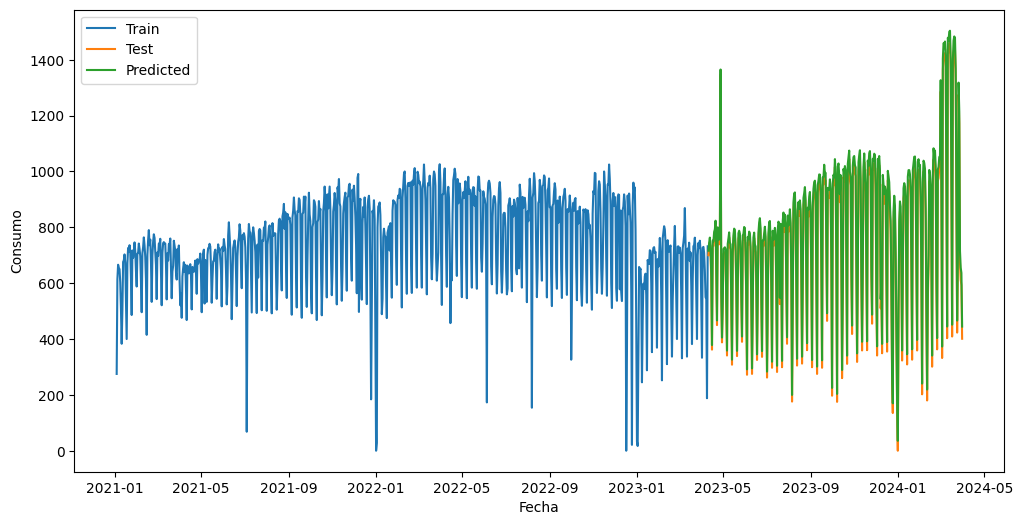

In [234]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train_endog, label='Train')
plt.plot(test_endog, label='Test')
plt.plot(pred_mean, label='Predicted')
plt.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=0.2)
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.legend()
plt.show()

In [235]:
#Calculamos MAE y RMSE
MAE = mean_absolute_error(test_endog, pred_mean)
RMSE = np.sqrt(mean_squared_error(test_endog, pred_mean))

#Calculamos MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPE = mean_absolute_percentage_error(comparison_df['Real'], comparison_df['Predicciones'])

print(f'*********************************************')
print(f'Métricas para el modelo SARIMAX (statsmodels)')
print(f'*********************************************')
print(f'MAE: {MAE}')
print(f'RMSE: {RMSE}')
print(f'MAPE: {MAPE}')

*********************************************
Métricas para el modelo SARIMAX (statsmodels)
*********************************************
MAE: 28.84379472073682
RMSE: 29.931063054187177
MAPE: inf


<ipython-input-235-514f9f8a857e>:8: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [236]:
# Calcular MBE
mbe = (pred_mean - test_endog['Cantidad Almuerzos']).mean()

# Mostrar los resultados
print(f"Mean Bias Error (MBE): {mbe}")

Mean Bias Error (MBE): 28.84379472073682


In [237]:
weights = np.ones_like(test_endog['Cantidad Almuerzos'])  # Por ejemplo, usar pesos iguales para simplificar
# Puedes modificar `weights` para asignar diferentes pesos a diferentes fechas

# Calcular WMAE
absolute_errors = np.abs(pred_mean - test_endog['Cantidad Almuerzos'])
wmae = np.sum(weights * absolute_errors) / np.sum(weights)

# Mostrar los resultados
print(f"Weighted Mean Absolute Error (WMAE): {wmae}")


Weighted Mean Absolute Error (WMAE): 28.84379472073682


In [238]:
#Actualizamos las metricas obtenidas del modelo 1 en el dataframe
dfmetricas.at[0,'Valor 1'] = wmae
dfmetricas.at[0,'Valor 2'] = mbe
dfmetricas

,Modelo,Metrica 1,Valor 1,Metrica 2,Valor 2
0,SARIMAX,WMAE,28.843795,MBE,28.843795
1,ARIMA,MAE,0.000000,MAPE,0.000000
2,REGRESIÓN LINEAL,MSE,0.000000,R2,0.000000
3,ARBOL DE REGRESIÓN,MSE,0.000000,R2,0.000000
4,REDES NEURONALES,MBE,0.000000,R2,0.000000
5,SVM,MAE,0.000000,WMAE,0.000000


⏰**Hasta aqui el modelo 1 sarimax con endogenas**



---


🦾 **Modelo 2: ARIMA**


---



In [239]:
# Datos de ejemplo (suponiendo que 'df' es tu DataFrame y 'fecha' es tu índice)
# df = pd.read_csv('ruta/a/tu/dataset.csv', parse_dates=['fecha'], index_col='fecha')

# Definir el modelo ARIMA
modelo_ARIMA = ARIMA(test_endog['Cantidad Almuerzos'], order=(p, d, q))

# Ajustar el modelo
results = modelo_ARIMA.fit()

# Hacer predicciones
predictions = results.get_forecast(steps=10)
predicted_mean = predictions.predicted_mean
confidence_intervals = predictions.conf_int()

print(predicted_mean)
print(confidence_intervals)


2024-04-01    414.671230
2024-04-02    412.915638
2024-04-03    412.317168
2024-04-04    411.631907
2024-04-05    410.953155
2024-04-06    410.273915
2024-04-07    409.594711
2024-04-08    408.915505
2024-04-09    408.236299
2024-04-10    407.557093
Freq: D, Name: predicted_mean, dtype: float64
            lower Cantidad Almuerzos  upper Cantidad Almuerzos
2024-04-01               -127.018133                956.360592
2024-04-02               -326.010682               1151.841958
2024-04-03               -483.834889               1308.469226
2024-04-04               -618.591469               1441.855282
2024-04-05               -738.427448               1560.333757
2024-04-06               -847.587968               1668.135797
2024-04-07               -948.633490               1767.822912
2024-04-08              -1043.247591               1861.078601
2024-04-09              -1132.606962               1949.079560
2024-04-10              -1217.572053               2032.686239


In [240]:
# Calcular los errores absolutos entre las predicciones y los valores reales
mae = mean_absolute_error(test_endog, pred_mean)
print(mae)

28.84379472073682


In [241]:

# #from sklearn.metrics import mean_absolute_error

# # Calcular los errores absolutos entre las predicciones y los valores reales
# errors = abs(test_endog - pred_mean)

# # Normalizar los pesos para que sumen 1
# weights = weights / np.sum(weights)

# # Verificar longitudes de datos
# assert len(test_endog) == len(pred_mean) == len(weights), "Las longitudes de los datos no coinciden"

# # Calcular el WMAE
# wmae = np.sum(errors * weights) / np.sum(weights)

# print("WMAE:", wmae)


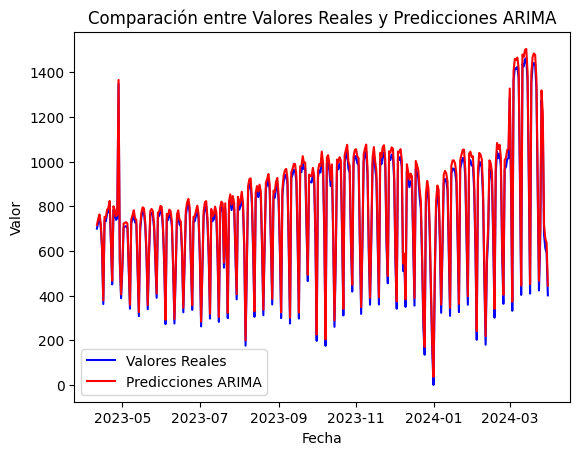

In [242]:
# Graficar los valores reales
plt.plot(test_endog, label='Valores Reales', color='blue')

# Graficar las predicciones
plt.plot(pred_mean, label='Predicciones ARIMA', color='red')

# Agregar etiquetas y leyenda
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Comparación entre Valores Reales y Predicciones ARIMA')
plt.legend()

# Mostrar la gráfica
plt.show()


In [243]:
#Actualizamos las metricas obtenidas del modelo 2 en el dataframe
dfmetricas.at[1,'Valor 1'] = mae
#dfmetricas.at[1,'Valor 2'] = mbe
dfmetricas

,Modelo,Metrica 1,Valor 1,Metrica 2,Valor 2
0,SARIMAX,WMAE,28.843795,MBE,28.843795
1,ARIMA,MAE,28.843795,MAPE,0.000000
2,REGRESIÓN LINEAL,MSE,0.000000,R2,0.000000
3,ARBOL DE REGRESIÓN,MSE,0.000000,R2,0.000000
4,REDES NEURONALES,MBE,0.000000,R2,0.000000
5,SVM,MAE,0.000000,WMAE,0.000000


⏰**Hasta aqui el modelo 2 ARIMA con endogenas**



---


🦾 **Modelo 3: REGRESIÓN LINEAL**


---


In [244]:
# Crear una instancia del modelo de regresión lineal
Modelo_REGRESION = LinearRegression()

# Entrenar el modelo utilizando los datos de entrenamiento
Modelo_REGRESION.fit(train_exog, train_endog)


LinearRegression()

In [245]:
# Hacer predicciones en el conjunto de prueba
predicciones = Modelo_REGRESION.predict(test_exog)


In [246]:
# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(test_endog, predicciones)

# Calcular el coeficiente de determinación (R²)
r2 = r2_score(test_endog, predicciones)

print("Error Cuadrático Medio (MSE):", mse)
print("Coeficiente de Determinación (R²):", r2)

Error Cuadrático Medio (MSE): 4.407920739185151e-26
Coeficiente de Determinación (R²): 1.0


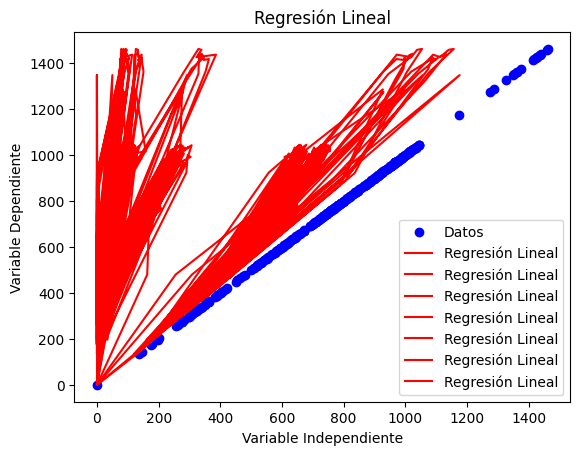

In [247]:
# Graficar los datos de dispersión (scatter plot)
plt.scatter(test_endog, predicciones, color='blue', label='Datos')

# Graficar la regresión lineal
plt.plot(test_exog, Modelo_REGRESION.predict(test_exog), color='red', label='Regresión Lineal')

# Agregar etiquetas y leyenda
plt.xlabel('Variable Independiente')
plt.ylabel('Variable Dependiente')
plt.title('Regresión Lineal')
plt.legend()

# Mostrar la gráfica
plt.show()


In [248]:
#Actualizamos las metricas obtenidas del modelo 1 en el dataframe
dfmetricas.at[2,'Valor 1'] = mse
dfmetricas.at[2,'Valor 2'] = r2
dfmetricas

,Modelo,Metrica 1,Valor 1,Metrica 2,Valor 2
0,SARIMAX,WMAE,2.884379e+01,MBE,28.843795
1,ARIMA,MAE,2.884379e+01,MAPE,0.000000
2,REGRESIÓN LINEAL,MSE,4.407921e-26,R2,1.000000
3,ARBOL DE REGRESIÓN,MSE,0.000000e+00,R2,0.000000
4,REDES NEURONALES,MBE,0.000000e+00,R2,0.000000
5,SVM,MAE,0.000000e+00,WMAE,0.000000


⏰**Hasta aqui el modelo 3 REGRESIÓN LINEAL**



---


🦾 **Modelo 4: ÁRBOL DE REGRESIÓN**


---


In [249]:
# Concatenar los DataFrames a lo largo de las columnas
df_concatenado = pd.concat([train_exog, train_endog], axis=1)

# Dividir los datos en conjuntos de entrenamiento y prueba
X = df_concatenado.drop(columns=["Cantidad Almuerzos"])  # Variables exógenas
y = df_concatenado["Cantidad Almuerzos"]  # Variable endógena

X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(X, y, test_size=0.2, random_state=42)

In [250]:
# Crear una instancia del modelo de árbol de regresión
modelo_arbol_regresion = DecisionTreeRegressor()

# Entrenar el modelo utilizando los datos de entrenamiento
modelo_arbol_regresion.fit(X_entrenamiento, y_entrenamiento)

DecisionTreeRegressor()

In [251]:
# Hacer predicciones en el conjunto de prueba
predicciones = modelo_arbol_regresion.predict(X_prueba)

# Mostrar las predicciones
print("Predicciones:", predicciones)

Predicciones: [ 690.  923.  857.  896.  496.  914.  763.  706.  854.  652.  701.  715.
  627.  741.  717.  772.  854.  476.  724.  801.  929.  530.  503.  884.
  854.  979.  672.  732.  492.  614.  779.  188.  646.  897.  729.  883.
  929.  724.  741.  742.  857.  545.  702.  865.  702.  739.  712.  519.
  863.  812.  909.  957. 1000.  850.  836.  562.  652.  310.  905.  923.
  543.  544.  918.  666.  860.  835.  687.  587.  969.  953.   28.  508.
  457.  645.  637.  400.  738.  612.  676.  736.  732.  942.  690.  766.
  833.  705.  741.  678.  563.  658.  918.  656.  795.  587.  948.  664.
  652.  497.  876.  891.  734.  679.  569.  666.  580.  707.  337.  874.
  664.  732.  562.  892.  672.  690.  690.  732.  562.  865. 1011.  679.
  643.  676.  584.  666.  865.  601.  891.  814.  887.  664.  690.  690.
  717.  876.  980. 1011. 1000.  737.  584.  645.  918.  980.  883.  637.
  863.  942.  935. 1000.  918.  921.  415.  805.  584.  640.  874.  907.
  679.  673.  717.  627.  910.  914. 

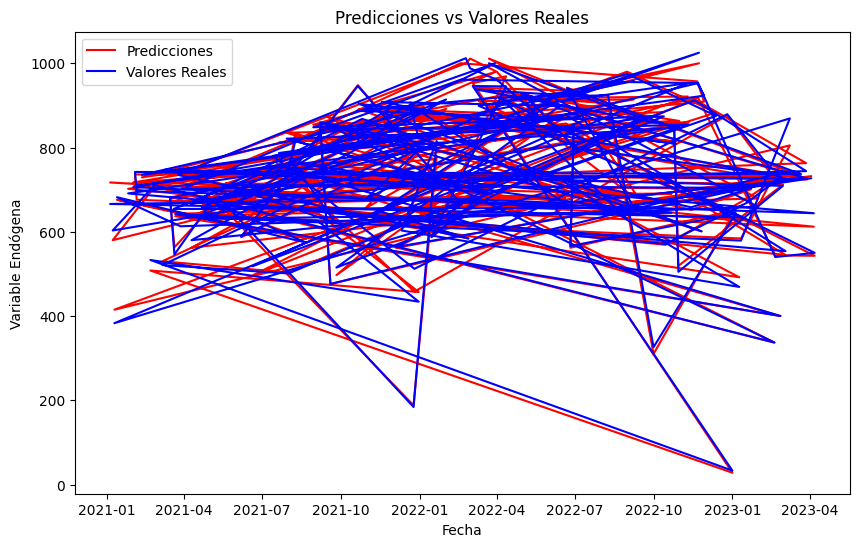

In [252]:
# Graficar los resultados
plt.figure(figsize=(10, 6))

# Graficar las predicciones
plt.plot(y_prueba.index, predicciones, label='Predicciones', color='red')

# Graficar los valores reales
plt.plot(y_prueba.index, y_prueba, label='Valores Reales', color='blue')

# Configurar etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Variable Endógena')
plt.title('Predicciones vs Valores Reales')

# Mostrar la leyenda
plt.legend()

# Mostrar la gráfica
plt.show()


In [253]:
# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(y_prueba, predicciones)
print("Error Cuadrático Medio (MSE):", mse)

Error Cuadrático Medio (MSE): 370.1265060240964


In [254]:
from sklearn.metrics import r2_score
# Calcular el R^2
r2 = r2_score(y_prueba, predicciones)
print("Coeficiente de Determinación (R^2):", r2)

Coeficiente de Determinación (R^2): 0.9865609528834324


In [255]:
#Actualizamos las metricas obtenidas del modelo 4 en el dataframe
dfmetricas.at[3,'Valor 1'] = mse
dfmetricas.at[3,'Valor 2'] = r2
dfmetricas

,Modelo,Metrica 1,Valor 1,Metrica 2,Valor 2
0,SARIMAX,WMAE,2.884379e+01,MBE,28.843795
1,ARIMA,MAE,2.884379e+01,MAPE,0.000000
2,REGRESIÓN LINEAL,MSE,4.407921e-26,R2,1.000000
3,ARBOL DE REGRESIÓN,MSE,3.701265e+02,R2,0.986561
4,REDES NEURONALES,MBE,0.000000e+00,R2,0.000000
5,SVM,MAE,0.000000e+00,WMAE,0.000000


⏰**Hasta aqui el modelo 4 ÁRBOL DE REGRESIÓN**


---


🦾 **Modelo 5: REDES NEURONALES**


---

In [ ]:
dfAlmuerzoAgrupado1 = dfAlmuerzoAgrupado
dfAlmuerzoAgrupado1['FechaO'] = dfAlmuerzoAgrupado1.index.map(pd.Timestamp.toordinal)
dfAlmuerzoAgrupado1.columns

Index(['Tipo Empleado_Administrativo', 'Tipo Empleado_Aprendices',
       'Tipo Empleado_Operativo', 'Porcentaje apoyo_0', 'Porcentaje apoyo_30',
       'Porcentaje apoyo_90', 'Porcentaje apoyo_100', 'Cantidad Almuerzos',
       'FechaO'],
      dtype='object')

In [ ]:
# Separar las características (X) y la etiqueta (y)
X = dfAlmuerzoAgrupado1[['FechaO', 'Tipo Empleado_Administrativo', 'Tipo Empleado_Aprendices', 'Tipo Empleado_Operativo','Porcentaje apoyo_0','Porcentaje apoyo_30','Porcentaje apoyo_90','Porcentaje apoyo_100']]
y = dfAlmuerzoAgrupado1['Cantidad Almuerzos']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Normalizar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Paso 2: Construir y entrenar el modelo de redes neuronales
model = Sequential()
model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train_scaled, y_train, epochs=50, batch_size=10, verbose=1)

Epoch 1/50
95/95 [==============================] - 1s 2ms/step - loss: 597736.5625
Epoch 2/50
95/95 [==============================] - 0s 2ms/step - loss: 533707.1875
Epoch 3/50
95/95 [==============================] - 0s 2ms/step - loss: 347448.5625
Epoch 4/50
95/95 [==============================] - 0s 2ms/step - loss: 136181.5625
Epoch 5/50
95/95 [==============================] - 0s 2ms/step - loss: 50870.8125
Epoch 6/50
95/95 [==============================] - 0s 2ms/step - loss: 28802.6289
Epoch 7/50
95/95 [==============================] - 0s 2ms/step - loss: 19600.7988
Epoch 8/50
95/95 [==============================] - 0s 2ms/step - loss: 14453.8457
Epoch 9/50
95/95 [==============================] - 0s 2ms/step - loss: 11235.6064
Epoch 10/50
95/95 [==============================] - 0s 2ms/step - loss: 9145.3916
Epoch 11/50
95/95 [==============================] - 0s 2ms/step - loss: 7734.5010
Epoch 12/50
95/95 [==============================] - 0s 2ms/step - loss: 6611.5967


In [ ]:
# Paso 3: Evaluar el modelo
loss = model.evaluate(X_test_scaled, y_test)
print(f'Model Loss: {loss}')

8/8 [==============================] - 0s 2ms/step - loss: 386.1374
Model Loss: 386.1374206542969


In [ ]:
# Predecir los valores
predictions = model.predict(X_test_scaled)

# Mostrar algunas predicciones
comparison = pd.DataFrame({'Real': y_test, 'Predicción': predictions.flatten()})
print(comparison.head())

8/8 [==============================] - 1s 9ms/step
             Real  Predicción
2021-11-18  908.0  911.503296
2023-08-17  872.0  855.987000
2024-01-02  480.0  534.190308
2021-03-30  701.0  712.806641
2023-09-20  997.0  955.232788


In [ ]:
# Calcular el MBE
mbe = np.mean(predictions.flatten() - y_test)
print(f'Mean Bias Error (MBE): {mbe}')

Mean Bias Error (MBE): -0.1221114371899311


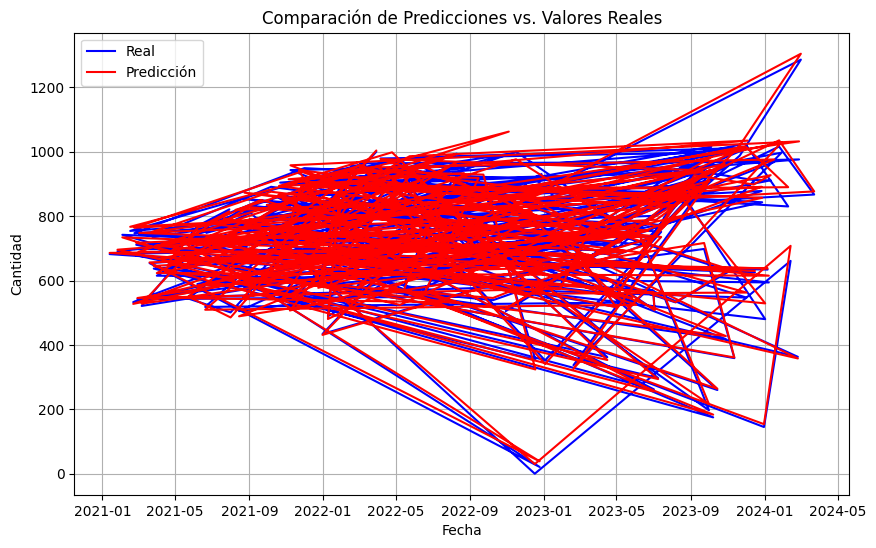

In [ ]:
# Graficar las predicciones
plt.figure(figsize=(10, 6))

# Graficar los valores reales
plt.plot(y_test.index, y_test, label='Real', color='blue')

# Graficar las predicciones
plt.plot(y_test.index, predictions.flatten(), label='Predicción', color='red')

plt.title('Comparación de Predicciones vs. Valores Reales')
plt.xlabel('Fecha')
plt.ylabel('Cantidad')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Actualizamos las metricas obtenidas del modelo 5 en el dataframe
dfmetricas.at[4,'Valor 1'] = mbe
#dfmetricas.at[4,'Valor 2'] = mbe
dfmetricas

,Modelo,Metrica 1,Valor 1,Metrica 2,Valor 2
0,SARIMAX,WMAE,2.884379e+01,MBE,28.843795
1,ARIMA,MAE,2.884379e+01,MAPE,0.000000
2,REGRESIÓN LINEAL,MSE,4.407921e-26,R2,1.000000
3,ARBOL DE REGRESIÓN,MSE,4.554096e+02,R2,0.000000
4,REDES NEURONALES,MBE,-1.221114e-01,R2,0.000000
5,SVM,MAE,0.000000e+00,WMAE,0.000000



---


🦾 **Modelo 6: SUPPORT VECTOR MACHINE (SVM)**


---

In [ ]:
dfAlmuerzoAgrupado1 = dfAlmuerzoAgrupado

# Separar las características (X) y la etiqueta (y)
X = dfAlmuerzoAgrupado1[['Tipo Empleado_Administrativo', 'Tipo Empleado_Aprendices', 'Tipo Empleado_Operativo','Porcentaje apoyo_0','Porcentaje apoyo_30','Porcentaje apoyo_90','Porcentaje apoyo_100']]
y = dfAlmuerzoAgrupado1['Cantidad Almuerzos']

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Crear un pipeline para escalar los datos y entrenar el modelo SVR
pipeline = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1))

# Ajustar el modelo a los datos de entrenamiento
pipeline.fit(X_train, y_train)

# Predecir los valores para los datos de prueba
predictions = pipeline.predict(X_test)

In [ ]:
# Calcular el MAE
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error (MAE): {mae}')

# Calcular el WMAE
weights = y_test

# Asegurarse de que no haya valores NaN en los pesos
weights = weights.fillna(0)

wmae = np.sum(weights * np.abs(predictions - y_test)) / np.sum(weights)
print(f'Weighted Mean Absolute Error (WMAE): {wmae}')

Mean Absolute Error (MAE): 2.8796714566188952
Weighted Mean Absolute Error (WMAE): 1.6410968775296177


In [ ]:
predictions

array([ 908.1212929 ,  872.80912402,  613.66343547,  701.02228932,
        996.52656515,  978.04630414,  629.62075522,  538.62041687,
        905.48509759,  828.73137137,  771.57785892,  157.26936495,
        663.40911762,  135.64835427,  809.71442562,  747.91462006,
        800.13230545,  876.66428724,  727.88321812,  514.11011979,
        907.70648486,  621.12465489,  651.86996511,  787.11887666,
        575.25099339,  867.92859911,  879.07673093,  530.30759789,
        517.25606465,  815.33077481,  691.08017167,  697.93616518,
        976.74657377,  896.16525402,  866.38105822,  691.09537963,
        363.29686861,  970.98147412,  887.73570948,  946.78503533,
        841.22270242,  548.24119006,  940.63632728,  911.00824413,
        909.76313417,  533.7102586 ,  888.42156618,  962.35980413,
        542.8736136 ,  548.66010438,  724.88986066,  550.70751642,
        848.8816008 ,  771.95702216,  821.06290957,  685.99555025,
       1006.36628204,  543.67367717,  710.80242416,  762.85651

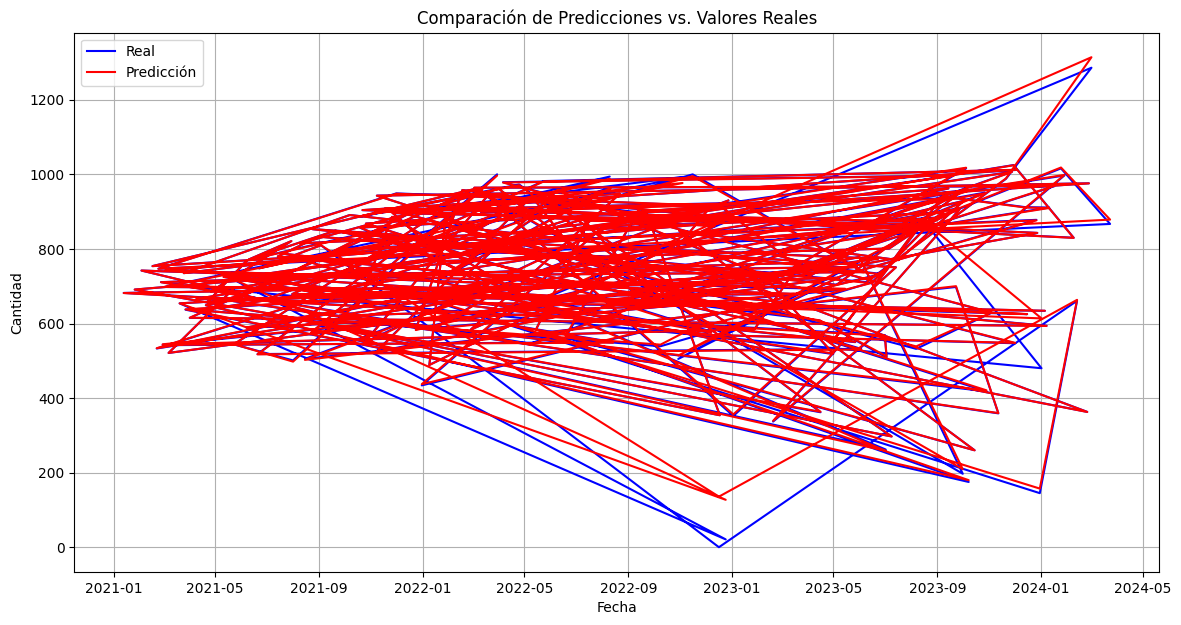

In [ ]:
import matplotlib.pyplot as plt

# Crear un DataFrame para facilitar la visualización
results = pd.DataFrame({'Real': y_test, 'Predicción': predictions}, index=y_test.index)

# Graficar los valores reales y las predicciones
plt.figure(figsize=(14, 7))
plt.plot(results.index, results['Real'], label='Real', color='blue')
plt.plot(results.index, results['Predicción'], label='Predicción', color='red')
plt.title('Comparación de Predicciones vs. Valores Reales')
plt.xlabel('Fecha')
plt.ylabel('Cantidad')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Actualizamos las metricas obtenidas del modelo 6 en el dataframe
dfmetricas.at[5,'Valor 1'] = mae
dfmetricas.at[5,'Valor 2'] = wmae
dfmetricas

,Modelo,Metrica 1,Valor 1,Metrica 2,Valor 2
0,SARIMAX,WMAE,2.884379e+01,MBE,28.843795
1,ARIMA,MAE,2.884379e+01,MAPE,0.000000
2,REGRESIÓN LINEAL,MSE,4.407921e-26,R2,1.000000
3,ARBOL DE REGRESIÓN,MSE,4.554096e+02,R2,0.000000
4,REDES NEURONALES,MBE,-1.221114e-01,R2,0.000000
5,SVM,MAE,2.879671e+00,WMAE,1.641097
